In [3]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from IPython.display import display
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
from typing import cast, Tuple
from random import randint

from ba_dev.dataset import MammaliaDataSequence, MammaliaDataImage
from ba_dev.transform import ImagePipeline, BatchImagePipeline
from ba_dev.utils import load_path_yaml
from ba_dev.eval_helpers import *

paths = load_path_yaml('../../data/path_config.yml')

set_custom_plot_style()
cm = 1 / 2.54

export = False

## Dataset analysis

In [8]:
label_files = paths['labels'].glob('*.csv')

raw_data = pd.DataFrame()

for label_file in label_files:
    new_data = pd.read_csv(label_file)
    raw_data = pd.concat([raw_data, new_data], ignore_index=True)

keys_to_keep = ['session', 'seq_id', 'Directory', 'n_files', 'all_files', 'label2']

all_sequences = raw_data[keys_to_keep].rename(columns={'label2': 'class_label'})

allowed_values = ['apodemus_sp', 'cricetidae', 'mustela_erminea', 'soricidae']

filtered_sequences = all_sequences[all_sequences['class_label'].isin(allowed_values)].copy()

filtered_sequences['all_files'] = filtered_sequences['all_files'].str.split(',')

filtered_sequences[['conf_values', 'bboxes', 'max_conf']] = (
    filtered_sequences
    .apply(
        lambda row: get_md_info(
            seq_id=row['seq_id'],
            files_list=row['all_files'],
            md_output_dir=paths['md_output']
        ),
        axis=1,
        result_type='expand'
    ))

sequence_df = filtered_sequences.copy()

image_df = (
    filtered_sequences
    .explode(['all_files', 'conf_values', 'bboxes'])
    .rename(columns={
        'all_files': 'file',
        'conf_values': 'conf_value',
        'bboxes': 'bbox'
        })
    .assign(path=lambda df: df['Directory'] + '/' + df['file'])
    .drop(columns=['max_conf', 'Directory'])
    .reset_index(drop=True)
    )


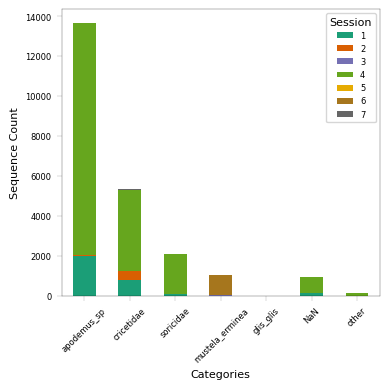

In [4]:
# Plot available Sequences per Label
########################################################################################################################
fig_name = "label2_session.pdf"
fig_size = (10*cm,10*cm)
########################################################################################################################

df = raw_data

df["label2"] = df["label2"].fillna("NaN")

counts = df.groupby(["label2", "session"]).size().unstack(fill_value=0)
counts["total"] = counts.sum(axis=1)

special_labels = ["NaN", "other"]

regular = counts[~counts.index.isin(special_labels)].sort_values("total", ascending=False)
special = counts[counts.index.isin(special_labels)]

counts_sorted = pd.concat([regular, special])
counts_sorted = counts_sorted.drop(columns="total")

# Create figure
fig, ax = plt.subplots(figsize=(fig_size[0], fig_size[1]))

counts_sorted.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    colormap="Dark2"
    )

ax.set_xlabel("Categories")
ax.set_ylabel("Sequence Count")
ax.tick_params(axis='x', rotation=45)
ax.legend(title="Session", loc='upper right')

plt.tight_layout()

if export:
    plt.savefig(paths['figures'] / fig_name, dpi=300)

plt.show()

Sequences with n_files > 50: 2209 (9.51%)
Sequences with n_files > 100: 738 (3.18%)
Sequences with n_files > 200: 157 (0.68%)
Sequences with n_files > 500: 11 (0.05%)

Top 10 sequence lengths:
[915 741 738 684 675 612 612 579 558 546]


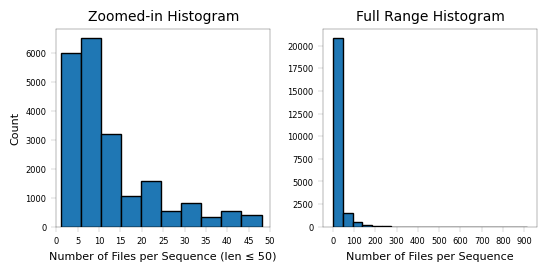

In [5]:
# Plot Histogram of Sequence Lengths
########################################################################################################################
fig_name = 'seq_len_histograms.pdf'
fig_size = (14*cm,7*cm)
########################################################################################################################

total_sequences = len(raw_data)

# Print percentage of sequences above each threshold
thresholds = [50, 100, 200, 500]
for t in thresholds:
    count = (df['n_files'] > t).sum()
    percent = count / total_sequences * 100
    print(f'Sequences with n_files > {t}: {count} ({percent:.2f}%)')

# Optionally, list the very largest sequence lengths
print('\nTop 10 sequence lengths:')
print(df['n_files'].nlargest(10).values)

plt.figure(figsize=fig_size)

ax1 = plt.subplot(1, 2, 1)
plt.hist(df['n_files'][df['n_files'] <= 50], bins=10, edgecolor='black')
plt.xlabel('Number of Files per Sequence (len ≤ 50)')
plt.ylabel('Count')
plt.title('Zoomed-in Histogram')
plt.xlim(0, 50)
ax1.set_xticks(np.arange(0, 51, 5))

# Right subplot: full range
ax2 = plt.subplot(1, 2, 2)
plt.hist(df['n_files'], bins=20, edgecolor='black')
plt.xlabel('Number of Files per Sequence')
plt.title('Full Range Histogram')
ax2.set_xticks(np.arange(0, 1000, 100))

plt.tight_layout()

if export:
    plt.savefig(paths['figures'] / fig_name, dpi=300)

plt.show()

In [4]:
# Session info table
########################################################################################################################
table_name = 'session_info'
caption = r'Information about the origin of the different sessions in the dataset.'
########################################################################################################################

session_info = {
    1 : "Data from 'the wild', collected durch Wiesel&Co 2019",
    2 : "Data from 'the wild', collected during WILMA (SummerSchool) 2020",
    3 : "Data from 'the wild', collected by Vogelwarte 2020",
    4 : "Data from 'the wild', collected by WILMA (Bachelorthesis) 2020",
    5 : "Data from 'the wild', collected by WILMA (Roland) 2020 (Contains images and videos of stoats (Mustela erminea))",
    6 : "Data from an enclosure, collected by Nils (Contains only images of stoats (Mustela erminea))",
    7 : "Data gathered from Nathalie Straub in her Bachelor Thesis"
    }

session_desc = pd.DataFrame.from_dict(
    session_info, 
    orient='index', 
    columns=['description']
    ).reset_index().rename(columns={'index': 'session'})

latex_str = session_desc.to_latex(
    index=False,
    column_format='c p{12cm}',
    escape=True,
    header=['Session', 'Description'],
    caption=caption,
    label=f'tab:{table_name}'
    )

latex_str = place_table(latex_str, center=True, placement='H')

print(latex_str)

if export:
    with open(paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex_str)


\begin{table}[H]
\centering
\caption{Information about the origin of the different sessions in the dataset.}
\label{tab:session_info}
\begin{tabular}{c p{12cm}}
\toprule
Session & Description \\
\midrule
1 & Data from 'the wild', collected durch Wiesel\&Co 2019 \\
2 & Data from 'the wild', collected during WILMA (SummerSchool) 2020 \\
3 & Data from 'the wild', collected by Vogelwarte 2020 \\
4 & Data from 'the wild', collected by WILMA (Bachelorthesis) 2020 \\
5 & Data from 'the wild', collected by WILMA (Roland) 2020 (Contains images and videos of stoats (Mustela erminea)) \\
6 & Data from an enclosure, collected by Nils (Contains only images of stoats (Mustela erminea)) \\
7 & Data gathered from Nathalie Straub in her Bachelor Thesis \\
\bottomrule
\end{tabular}
\end{table}


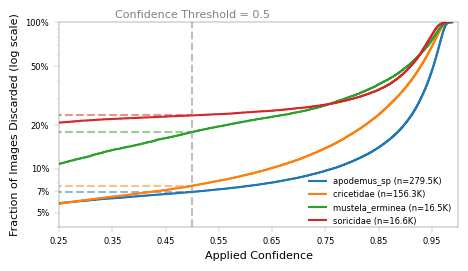

In [ ]:
# Plot Fraction of Discarded Images by Applied Confidence
########################################################################################################################
fig_name = 'discarded_img_by_conf.pdf'
fig_size = (12*cm,7*cm)
conf_threshold = 0.5
########################################################################################################################

df = image_df

cdf_data = (
    df.sort_values(by='conf_value')
      .groupby('class_label', group_keys=False)
      .apply(lambda g: pd.DataFrame({
          'conf_value': np.sort(g['conf_value'].to_numpy()),
          'cum_density': np.linspace(0, 1, len(g)),
          'class_label': g.name  # this is the current group label
      }), include_groups=False)
      .reset_index(drop=True)
)

# Plotting
class_counts = df['class_label'].value_counts().to_dict()

plt.figure(figsize=fig_size)
for class_label, group in cdf_data.groupby('class_label'):
    count = class_counts.get(class_label, 0)
    label = f'{class_label} (n={count/1000:.1f}K)'
    
    line, = plt.plot(group['conf_value'], group['cum_density'], label=label)

    above_thresh = group[group['conf_value'] >= conf_threshold]
    if not above_thresh.empty:
        y_at_thresh = above_thresh['cum_density'].iloc[0]
        plt.hlines(y=y_at_thresh, xmin=0.24, xmax=conf_threshold, linestyle='--', alpha=0.5, color=line.get_color())

plt.axvline(x=conf_threshold, linestyle='--', color='gray', alpha=0.5)
plt.text(
    x=conf_threshold, y=1.08,
    s=f'Confidence Threshold = {conf_threshold}',
    horizontalalignment='center',
    fontsize=8,
    color='gray'
)

plt.xlabel('Applied Confidence')
plt.ylabel('Fraction of Images Discarded (log scale)')
plt.yscale('log')
plt.yticks(
    [0.05, 0.07, 0.1, 0.2, 0.5, 1], 
    labels=['5%', '7%', '10%', '20%', '50%', '100%']
    )
plt.xticks(
    np.arange(0.25, 1, 0.1),
    labels=[f'{x:.2f}' for x in np.arange(0.25, 1, 0.1)]
)
plt.legend(
    loc='lower right',
    bbox_to_anchor=(1, -0.03),
    frameon=False
)
plt.xlim(left=0.25, right=1)
plt.ylim(bottom=0.04, top=1)
plt.tight_layout()

if export is not None:
    plt.savefig(paths['figures'] / fig_name, dpi=300)
    
plt.show()

In [ ]:
# MD output - data available
########################################################################################################################
table_name = 'data_availability_after_md'
caption = r'Data loss dew to MD output for confidence thresholds of 0.25 and 0.5 by category.'
########################################################################################################################

df_seq = count_vs_threshold(sequence_df, thresholds=[0.25, 0.5], base_name="seq")
df_img = count_vs_threshold(image_df, thresholds=[0.25, 0.5], base_name="img")
joined_df = df_seq.merge(df_img, on='class_label')

keys = joined_df.keys()

lines = [
        '\\begin{table}',
        f'\\caption{{{caption}}}',
        f'\\label{{tab:{table_name}}}',
        '\\begin{tabular}{l r r r r}',
        '\\toprule'
        ]

last = 'first'
key_l = ''
treshold = '0'

for key in keys:

    info = key.split('_')

    if info[0] != last:
        
        if info[0] == 'seq':
            lines.append('\midrule')
            lines.append('\\textbf{Sequence Level} & & & & \\\\')
        elif info[0] == 'img':
            lines.append('\midrule')
            lines.append('\midrule')
            lines.append('\\textbf{Image Level} & & & & \\\\')
        
    last = info[0]
    
    if len(info) == 2:
        key_l = 'Total available'
    elif len(info) == 3:
        if info[2] != treshold:
            lines.append('\midrule')
            lines.append(f'Threshold of {info[2]}: & & & & \\\\')
            treshold = info[2]

        if info[1] == 'lost':
            key_l = 'Lost'
        elif info[1] == 'frac':
            key_l = 'Fraction lost'
        elif info[1] == 'avail':
            key_l = 'Available'


    data = joined_df[key].values

    data_str = ''

    for value in data:
        if isinstance(value, str):
            value = value.replace('_', '\_')
            key_l = ''
        else:
            value = str(value)
        
        data_str += ' & ' + value

    new_line = key_l + data_str + ' \\\\'
    lines.append(new_line)

lines.extend([
    '\\bottomrule',
    '\\end{tabular}',
    '\\end{table}'
    ])

latex = "\n".join(lines)
latex = place_table(latex, center=True, placement='H')

print(latex)

if export:
    with open(paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex)

\begin{table}[H]
\centering
\caption{Data loss dew to MD output for confidence thresholds of 0.25 and 0.5 by category.}
\label{tab:data_availability_after_md}
\begin{tabular}{l r r r r}
\toprule
 & apodemus\_sp & cricetidae & mustela\_erminea & soricidae \\
\midrule
\textbf{Sequence Level} & & & & \\
Total available & 13669 & 5329 & 1035 & 2107 \\
\midrule
Threshold of 0.25: & & & & \\
Lost & 51 & 40 & 211 & 7 \\
Fraction lost & 0.0 & 0.01 & 0.2 & 0.0 \\
Available & 13618 & 5289 & 824 & 2100 \\
\midrule
Threshold of 0.5: & & & & \\
Lost & 56 & 46 & 239 & 13 \\
Fraction lost & 0.0 & 0.01 & 0.23 & 0.01 \\
Available & 13613 & 5283 & 796 & 2094 \\
\midrule
\midrule
\textbf{Image Level} & & & & \\
Total available & 279492 & 156350 & 16465 & 16645 \\
\midrule
Threshold of 0.25: & & & & \\
Lost & 16609 & 9248 & 2914 & 3529 \\
Fraction lost & 0.06 & 0.06 & 0.18 & 0.21 \\
Available & 262883 & 147102 & 13551 & 13116 \\
\midrule
Threshold of 0.5: & & & & \\
Lost & 19417 & 11948 & 3290 & 3865 \\
F

/Users/jk/MyPythonPackages/BA_package/ba_dev/dataset.py:249: UserWarning: With the detection confidence of 0.25,
309 sequences had no detections and will be excluded.
Excluded sequences: [6000646, 6000663, 6000665, 6000679, 6000680, 6000681, 6000683, 4001841, 1001523, 6000691] ...
  warnings.warn(


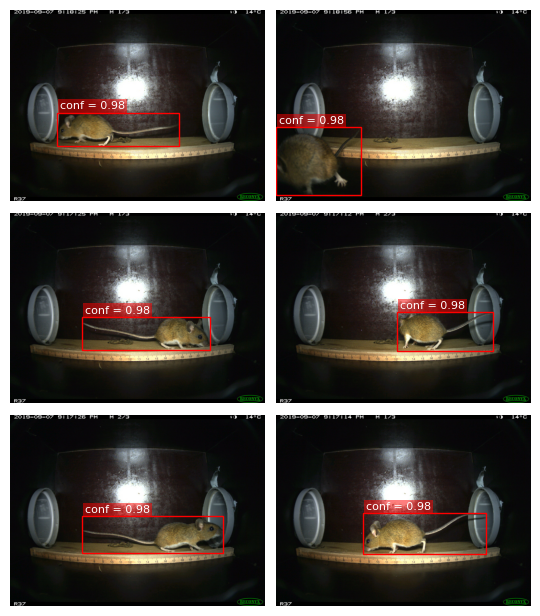

In [9]:
# Detections of a Sequence
########################################################################################################################
fig_name = 'detections_on_a_sequence.pdf'
fig_width = 14*cm
seq_id = 1001824
scaling_factor = 0.5
########################################################################################################################


dataset_seq = MammaliaDataSequence(
    path_labelfiles=paths['labels'],
    path_to_dataset=paths['dataset'],
    path_to_detector_output=paths['md_output'],
    detector_model=None,
    mode='eval'
    )

i = dataset_seq.get_index_by_seq_id(seq_id)
sequence = dataset_seq[i]

length = len(sequence['sample'])

if length >= 6:
    nrows = 3
    ncols = 2
else:
    raise ValueError("The sequence is too short to be displayed in a 3x2 grid.")

fig = plt.figure(figsize=(fig_width, fig_width * nrows / ncols * 3/4))
gs = GridSpec(
    nrows=nrows, ncols=ncols,
    figure=fig,
    )

for col in range(ncols):
    for row in range(nrows):
        ax = fig.add_subplot(gs[row, col])

        if col == 0:
            idx = row
        else:
            idx = -(nrows - row)

        img = sequence['sample'][idx]
        bbox = sequence['bbox'][idx]
        conf = sequence['conf'][idx]

        draw_bbox_on_ax(ax, img, bbox, conf)

fig.tight_layout()

if export:
    plt.savefig(paths['figures'] / fig_name, dpi=300)
    
plt.show()

## Model analysis

### Balanced Accuracy of all Models

In [8]:
# # calculating the balanced accuracy score for all runs
# bal_acc = evaluate_all_runs(
#     path_to_runs=paths['complete_models'],
#     metrics='balanced_accuracy_score',
#     )

# bal_acc.to_csv('bal_acc.csv', index=False)

bal_acc = pd.read_csv('bal_acc.csv')

In [9]:
# Balanced accuracy Table for all models
########################################################################################################################
table_name = 'bal_acc_by_model'
caption = r'Balanced accuracy of all models -- shown as mean ± standard deviation.'
########################################################################################################################

summary_bal_acc = (
    bal_acc
    .groupby(['model_name', 'pretrained'])
    .agg(
        trainable_params=('trainable_params', 'first'),
        img_score_mean=('img_score', 'mean'),
        img_score_std =('img_score', 'std'),
        seq_score_mean=('seq_score', 'mean'),
        seq_score_std =('seq_score', 'std'),
    )
    .reset_index()
    .sort_values(
        by=['pretrained', 'trainable_params'],
        ascending=[False, True]
    )
    )

for scope in ['img', 'seq']:
    mean_str = summary_bal_acc[f'{scope}_score_mean'].map("{:.4f}".format)
    std_str  = summary_bal_acc[f'{scope}_score_std'].map("{:.3f}".format)
    summary_bal_acc[f'bal_acc_{scope}'] = mean_str + ' ± ' + std_str

table = (
        summary_bal_acc[
            ['model_name', 'pretrained', 'trainable_params', 'bal_acc_img', 'bal_acc_seq']
        ]
        .rename(columns={
            'model_name': 'Model',
            'pretrained': 'Pretrained',
            'trainable_params': 'Params (M)',
            'bal_acc_img': r'Image BA-Score',
            'bal_acc_seq': r'Sequence BA-Score'
        }))

table['Params (M)'] = (table['Params (M)'] / 1_000_000).astype(int)
table['Pretrained'] = table['Pretrained'].map({True: 'Yes', False: 'No'})

latex = table.to_latex(
    index=False,
    column_format='l c r c c',
    escape=True,
    caption=caption,
    label=f'tab:{table_name}',
    )

lines = latex.splitlines()

for i, line in enumerate(lines):
    if '& No &' in line:
        split_index = i
        break

new_lines = lines[:split_index] + ['\midrule'] + lines[split_index:]

latex = "\n".join(new_lines)

latex = place_table(latex, center=True, placement='H')

print(latex)

if export:
    with open(paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex)


\begin{table}[H]
\centering
\caption{Balanced accuracy of all models -- shown as mean ± standard deviation.}
\label{tab:bal_acc_by_model}
\begin{tabular}{l c r c c}
\toprule
Model & Pretrained & Params (M) & Image BA-Score & Sequence BA-Score \\
\midrule
efficientnet\_b0 & Yes & 4 & 0.9921 ± 0.004 & 0.9947 ± 0.002 \\
densenet169 & Yes & 12 & 0.9904 ± 0.004 & 0.9939 ± 0.002 \\
resnet50 & Yes & 23 & 0.9899 ± 0.004 & 0.9934 ± 0.002 \\
vit\_b\_16 & Yes & 85 & 0.9885 ± 0.005 & 0.9933 ± 0.002 \\
\midrule
efficientnet\_b0 & No & 4 & 0.9856 ± 0.005 & 0.9898 ± 0.003 \\
densenet169 & No & 12 & 0.9863 ± 0.006 & 0.9899 ± 0.002 \\
resnet50 & No & 23 & 0.9850 ± 0.004 & 0.9888 ± 0.003 \\
vit\_b\_16 & No & 85 & 0.9767 ± 0.006 & 0.9856 ± 0.004 \\
\bottomrule
\end{tabular}
\end{table}


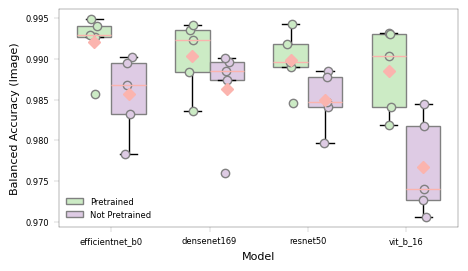

In [10]:
# Box Plot for Balanced Accuracy by Model and Pretrained Status
########################################################################################################################
fig_name = 'bal_acc_img.pdf'
fig_size = (12*cm,7*cm)
########################################################################################################################

models = ['efficientnet_b0', 'densenet169','resnet50', 'vit_b_16']
n = len(models)
x = range(n)
width = 0.35

data_pre = [
    bal_acc[(bal_acc['model_name']==m) & (bal_acc['pretrained'])]['img_score'] 
    for m in models
    ]
data_no = [
    bal_acc[(bal_acc['model_name']==m) & (~bal_acc['pretrained'])]['img_score'] 
    for m in models
    ]

cmap = plt.get_cmap('Pastel1')
color_pre = cmap(2)
color_no  = cmap(3)
red = cmap(0)

plt.figure(figsize=fig_size)

medianprops = dict(linewidth=1, color=red)

meanprops = dict(
                marker='D',
                markeredgecolor=red,
                markerfacecolor=red,
                markersize=6
                )

flierprops = dict(marker='', linestyle='none')

bp_pre = plt.boxplot(
    data_pre,
    positions=[i - width/2 for i in x],
    widths=width,
    patch_artist=True,
    manage_ticks=False,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops,
    flierprops=flierprops
    )
bp_no = plt.boxplot(
    data_no,
    positions=[i + width/2 for i in x],
    widths=width,
    patch_artist=True,
    manage_ticks=False,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops,
    flierprops=flierprops
    )

for box in bp_pre['boxes']:
    box.set_facecolor(color_pre)
    box.set_edgecolor('gray')
for box in bp_no['boxes']:
    box.set_facecolor(color_no)
    box.set_edgecolor('gray')

plt.xticks(x, models, ha='center')
plt.xlabel('Model')
plt.ylabel('Balanced Accuracy (Image)')

legend_handles = [
    Patch(facecolor=color_pre, edgecolor='gray', label='Pretrained'),
    Patch(facecolor=color_no,  edgecolor='gray', label='Not Pretrained')
    ]
plt.legend(handles=legend_handles, frameon=False, loc='lower left')

for i, m in enumerate(models):
    y_pre = bal_acc[(bal_acc['model_name']==m) & (bal_acc['pretrained'])]['img_score']
    x_pre = np.random.normal(i - width/2, width*0.05, size=len(y_pre))
    plt.scatter(x_pre, y_pre, color=color_pre, edgecolor='gray', zorder=2)

    y_no  = bal_acc[(bal_acc['model_name']==m) & (~bal_acc['pretrained'])]['img_score']
    x_no  = np.random.normal(i + width/2, width*0.05, size=len(y_no))
    plt.scatter(x_no, y_no, color=color_no,  edgecolor='gray', zorder=2)


plt.tight_layout()

if export:
    plt.savefig(paths['figures'] / fig_name, dpi=300)
plt.show()

### Performance of Best Model

In [11]:
# Determine the best model based on the balanced accuracy score and load predictions

summary = (
    bal_acc
    .groupby(['model_name', 'pretrained'])
    .agg(
        experiment_name=('experiment_name', 'first'),
        img_score_mean=('img_score', 'mean'),
    )
    .reset_index()
    )

best_row = summary.loc[summary['img_score_mean'].idxmax()]

best_experiment_path = paths['complete_models'] / str(best_row['experiment_name'])

best_model = LoadRun(
    log_path=best_experiment_path
)

all_testsets = pd.DataFrame()

for fold in range(5):
    new_data = best_model.get_predictions(
        set_selection='test',
        fold=fold
        )
    
    new_data['fold'] = fold
    
    all_testsets = pd.concat([all_testsets, new_data], ignore_index=True)

y_true = all_testsets['class_id'].to_list()
y_pred = all_testsets['pred_id'].to_list()


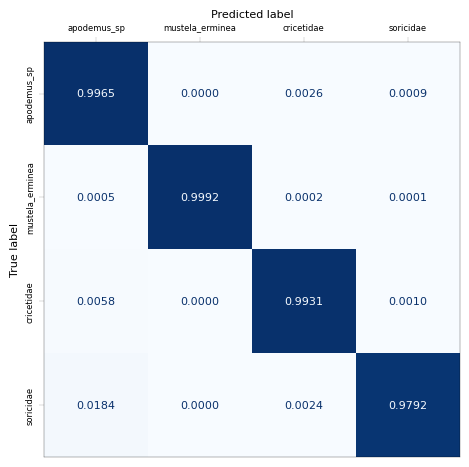

In [12]:
# Confusion Matrix for the best model
########################################################################################################################
fig_name = 'conf_matrix_best.pdf'
fig_size = (12*cm,12*cm)
########################################################################################################################

labels = list(best_model.decoder.values())

confusion_matrix = metrics.confusion_matrix(
    y_true,
    y_pred,
    labels=list(best_model.decoder.keys()),
    normalize='true'
)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=labels)
fig, ax = plt.subplots(figsize=fig_size)
disp.plot(
    ax=ax,
    cmap='Blues',
    colorbar=False,
    values_format='.4f'
)

n = len(labels)
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=90, va='center')

plt.tight_layout()
if export:
        plt.savefig(paths['figures'] / fig_name, dpi=300)
plt.show()

In [13]:
# Precision, Recall and F1-Score for the best model
########################################################################################################################
table_name = 'precision_recall_fscore_support'
caption = r'Class-wise precision, recall, F1-score, and support for the best-performing model.'
########################################################################################################################

labels_ids = [k for k in best_model.decoder]

result  = metrics.precision_recall_fscore_support(
    y_true,
    y_pred,
    labels=list(best_model.decoder.keys()),
    zero_division=0
    )

precision, recall, f1_score, support = cast(
    Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray],
    result
    )

data = []
for i, label in enumerate(list(best_model.decoder.values())):
    data.append({
        'Class'    : label,
        'Precision': precision[i],
        'Recall'   : recall[i],
        'F1-Score' : f1_score[i],
        'Support'  : int(support[i]),
    })

df = pd.DataFrame(data)

latex = df.to_latex(
    index=False,
    column_format='l r r r r',
    escape=True,
    float_format="%.3f",
    caption=caption,
    label=f'tab:{table_name}',
    )

latex = place_table(latex, center=True, placement='H')

print(latex)

if export:
    with open(paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex)


\begin{table}[H]
\centering
\caption{Class-wise precision, recall, F1-score, and support for the best-performing model.}
\label{tab:precision_recall_fscore_support}
\begin{tabular}{l r r r r}
\toprule
Class & Precision & Recall & F1-Score & Support \\
\midrule
apodemus\_sp & 0.996 & 0.997 & 0.996 & 260075 \\
mustela\_erminea & 0.999 & 0.999 & 0.999 & 13175 \\
cricetidae & 0.995 & 0.993 & 0.994 & 144402 \\
soricidae & 0.971 & 0.979 & 0.975 & 12780 \\
\bottomrule
\end{tabular}
\end{table}


## Visual inspection

In [ ]:
# fixed list in fixed order

mustela_erminea_nodetect = [22374, 35835, 33248, 421320, 421394, 421465, 421507, 421590, 421664, 421712, 421959, 423864]
order = [0, 1, 2, 5, 6, 10, 11, 3, 4, 7, 8, 9]
mustela_erminea_nodetect = [mustela_erminea_nodetect[i] for i in order]

filtered_image_df = image_df.loc[mustela_erminea_nodetect]

In [ ]:
# filtered and sorted

filter = (image_df["conf_value"] >= 0.5) & (image_df["class_label"] == "mustela_erminea")
filtered_image_df = image_df.where(filter).dropna().sort_values(by='conf_value', ascending=False)

In [ ]:
# set up for plotting chunks
chunk_size = 12
start_id = 0
end_id = start_id + chunk_size

n_chunks = (len(filtered_image_df) + chunk_size - 1) // chunk_size

selected_original_indices = []

In [ ]:
# plotting chunks

current_chunk = end_id // chunk_size
print(f'Processing chunk {current_chunk} of {n_chunks}')
chunk = filtered_image_df.iloc[start_id:end_id]
start_id = end_id
end_id = start_id + chunk_size

fig_width = 24*cm
ncols = 3
nrows = (len(chunk) + ncols - 1) // ncols

fig = plt.figure(figsize=(fig_width, fig_width * nrows / ncols * 3/4))
gs = GridSpec(
    nrows=nrows, ncols=ncols,
    figure=fig,
    )

for idx, (_, row) in enumerate(chunk.iterrows()):

    ax = fig.add_subplot(gs[idx // ncols, idx % ncols])


    file_path = paths['dataset'] / row['path']

    img = Image.open(file_path)
    bbox = row['bbox']
    conf = row['conf_value']

    ax.annotate(
        f"{idx}",
        xy=(0.01, 0.98),
        xycoords=ax.transAxes,
        fontsize=10,
        color="red",
        ha="left",
        va="top",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, pad=1.5)
    )

    draw_bbox_on_ax(ax, img, bbox, conf)           

fig.tight_layout()

# fig.savefig(paths['figures'] / 'mustela_special_nodetect.pdf', dpi=300)
    